# **Dataset & Description**



[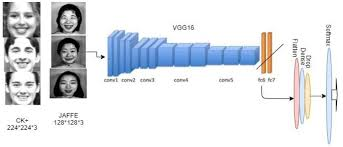](http://)


The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples.








[Dataset link ](https://www.kaggle.com/msambare/fer2013)

# Import necessary python libraries

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sn
# import skimage.io
# import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
# from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

# Data Preprocessing

In [36]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [37]:
train_dataset  = train_datagen.flow_from_directory(directory = 'Dataset/train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64,
                                                   shuffle = True)

Found 22968 images belonging to 7 classes.


In [38]:
valid_dataset = valid_datagen.flow_from_directory(directory = 'Dataset/train',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 5741 images belonging to 7 classes.


In [39]:
test_dataset = test_datagen.flow_from_directory(directory = 'Dataset/test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 7178 images belonging to 7 classes.


In [40]:
base_model = tf.keras.applications.VGG16(input_shape=(48,48,3),include_top=False,weights="imagenet")

In [41]:
# Freezing Layers

for layer in base_model.layers[:-4]:
    layer.trainable=False

In [42]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))

In [43]:
# Model Summary

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 dropout_6 (Dropout)         (None, 1, 1, 512)         0         
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 batch_normalization_8 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 32)                16416     
                                                                 
 batch_normalization_9 (Batc  (None, 32)               128       
 hNormalization)                                      

In [44]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',
                        patience = 20,
                        verbose = 1,
                        factor = 0.50,
                        min_lr = 1e-10
                        )

mcp = ModelCheckpoint('Models/cb_vgg16.h5',
                        monitor='val_acc')

es = EarlyStopping(verbose=1,
                        patience=20,
                        restore_best_weights=True #restoring the best model
                        )

In [45]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [46]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 100,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/100
359/359 [==============================] - 629s 2s/step - loss: 1.9079 - accuracy: 0.2096 - val_loss: 1.8273 - val_accuracy: 0.2200 - lr: 0.0010
Epoch 2/100
359/359 [==============================] - 355s 987ms/step - loss: 1.8301 - accuracy: 0.2355 - val_loss: 1.8040 - val_accuracy: 0.2512 - lr: 0.0010
Epoch 3/100
359/359 [==============================] - 295s 822ms/step - loss: 1.7742 - accuracy: 0.2665 - val_loss: 1.7099 - val_accuracy: 0.2999 - lr: 0.0010
Epoch 4/100
359/359 [==============================] - 312s 870ms/step - loss: 1.7520 - accuracy: 0.2783 - val_loss: 1.8153 - val_accuracy: 0.2595 - lr: 0.0010
Epoch 5/100
359/359 [==============================] - 278s 774ms/step - loss: 1.7284 - accuracy: 0.2925 - val_loss: 1.7671 - val_accuracy: 0.2785 - lr: 0.0010
Epoch 6/100
359/359 [==============================] - 312s 870ms/step - loss: 1.7177 - accuracy: 0.2969 - val_loss: 2.3368 - val_accuracy: 0.2148 - lr: 0.0010
Epoch 7/100
359/359 [======================

In [47]:
model.save('Models/vgg16_v1.h5')

# Data Postprocessing

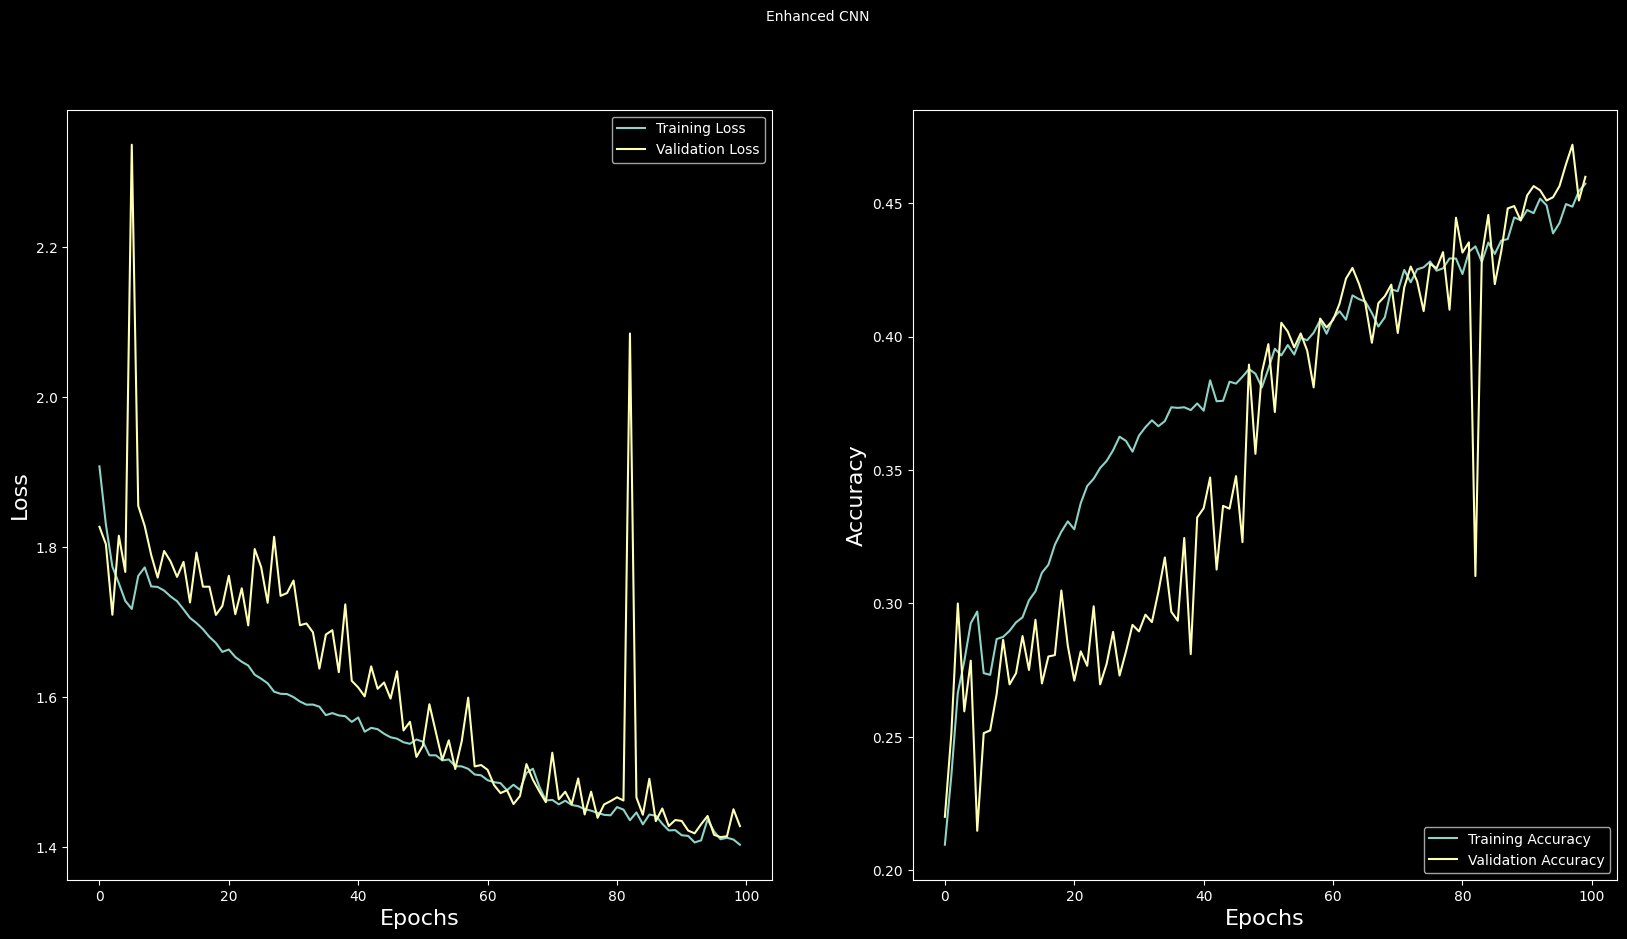

In [54]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Enhanced CNN', fontsize=10)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Load a model

In [49]:
from tensorflow.keras.models import load_model

model = load_model('Models/vgg16_v2.h5', compile = True)

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 1, 1, 512)         0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                16416     
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

# Test a model

In [51]:
results = model.evaluate(test_dataset)
results

113/113 [==============================] - 154s 1s/step - loss: 1.5346 - accuracy: 0.3881


[1.5345693826675415, 0.38813039660453796]

# Create Confusion Matrix

In [52]:
# Finding prediction for the test dataset
predictions = model.predict(test_dataset)

# Categorizing test dataset based on predictions
test_prediction = []
for i in range(test_dataset.samples):
    idx = np.argmax(predictions[i])
    test_prediction.append(idx)

113/113 [==============================] - 51s 450ms/step


In [53]:
# Defining labels of Confusion Matrix
emotions = test_dataset.class_indices

# Creating Confusion matrix
res = tf.math.confusion_matrix(test_prediction, test_dataset.classes).numpy()
cm = pd.DataFrame(res, index=emotions, columns=emotions)
cm

,angry,disgust,fear,happy,neutral,sad,surprise
angry,0,0,0,0,0,0,0
disgust,0,0,0,0,0,0,0
fear,66,9,58,86,67,75,54
happy,285,37,347,557,374,410,231
neutral,46,5,42,85,54,65,49
sad,331,39,325,627,452,403,298
surprise,230,21,252,419,286,294,199
